## Overview
This notebook processes Toronto road network and collision data to create a timeseries dataset for an accident prediction model for the Toronto downtown core. It also contains a traffic accident risk prediction model that is trained on this dataset for the Toronto downtown core.

The dataset sources are:
1. [NRN Ontario GeoPackage](https://open.canada.ca/data/en/dataset/3d282116-e556-400c-9306-ca1a3cada77f/resource/d07a84dd-863c-4d60-9c08-0b33b6120427)
2. [Toronto neighbourhood spatial data](https://open.toronto.ca/dataset/neighbourhoods/)
3. [Toronto collision dataset](https://open.toronto.ca/dataset/police-annual-statistical-report-traffic-collisions/)

## Part 0: Notebook setup

First installing useful modules:

In [ ]:
!pip install geopandas shapely torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.2 MB/s eta 0:00:00


Next, importing necessary modules:

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch_geometric as pyg
import matplotlib.pyplot as plt

from datetime import datetime
from zoneinfo import ZoneInfo

import shapely
from shapely.geometry import Point

## Part 1: Preprocessing GeoDataFrames

### 1.1: Extracting raw data

Mounting google drive and changing working directory:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Note: paste your own working directory here and then run the cell proceed with the next steps

#%cd "/content/drive/MyDrive/2. UofT/2024-2025 (PEY)/Summer 2025/APS360 (2025)/APS360 2025 Project"
%cd "/content/drive/MyDrive/SUMMER 2025/APS360/PROJECT DATA/APS360 2025 Project"
#nic's above

#%cd "/content/drive/MyDrive/APS360 2025 Project"
#will


/content/drive/.shortcut-targets-by-id/1F2sqecbViHh2YccLNXVFI3C1YDjdrDs4/APS360 2025 Project


Loading raw datasets and converting to GeoDataFrames

In [ ]:
# Available layers: 'NRN_ON_18_0_TOLLPOINT' (default), 'NRN_ON_18_0_FERRYSEG', 'NRN_ON_18_0_JUNCTION',
# 'NRN_ON_18_0_ROADSEG', 'NRN_ON_18_0_BLKPASSAGE', 'NRN_ON_18_0_STRPLANAME', 'NRN_ON_18_0_ADDRANGE'
roads_gpd = gpd.read_file("./3. Data and processing/DTC Road Network Data/NRN_RRN_ON_GPKG/NRN_ON_18_0_GPKG_en.gpkg", \
                          layer = 'NRN_ON_18_0_ROADSEG')

# Making neighbourhoods gpd:
nbhds_gpd = gpd.read_file("./3. Data and processing/DTC Road Network Data/Neighbourhoods - 4326.gpkg")

# Making collisions gpd:
collisions_gpd = gpd.read_file('./3. Data and processing/Toronto Collision Data/Traffic Collisions - 4326.gpkg')

### 1.2: Clipping datasets to Toronto downtown core

In [ ]:
##################################################################
## creating downtown core polygon
##################################################################

# Making list of neighbourhoods in Toronto downtown core
dtc_nbhds_list = ['Annex', 'University', 'Kensington-Chinatown', 'Wellington Place', 'Bay-Cloverhill', \
             'Yonge-Bay Corridor', 'Church-Wellesley', 'Downtown Yonge East', 'North St.James Town', \
             'Cabbagetown-South St.James Town', 'Moss Park', 'Regent Park', 'Harbourfront-CityPlace']

# Filtering to downtown core neighhbourhoods
dtc_nbhds_gpd = nbhds_gpd[nbhds_gpd['AREA_NAME'].isin(dtc_nbhds_list)]

# Dissolving interior boundaries to create a single polygon
dtc_nbhds_gpd = dtc_nbhds_gpd.dissolve()


# Reprojecting all gpds to match NRN road network (just in case)
dtc_nbhds_gpd = dtc_nbhds_gpd.to_crs(epsg=4617)
colls_gpd = collisions_gpd.to_crs(epsg=4617)


##################################################################
## using polygon to clip the NRN road network
##################################################################

roads_gpd_clipped = gpd.clip(roads_gpd, dtc_nbhds_gpd['geometry'], keep_geom_type=True)
colls_gpd_clipped = gpd.clip(colls_gpd, dtc_nbhds_gpd['geometry'], keep_geom_type=True)

In [ ]:
#print("Road Information")
#print(roads_gpd_clipped)
#print("Collision Information")
#print(colls_gpd_clipped)

isolated_road_information = roads_gpd_clipped[["PAVSTATUS", "ROADCLASS", "NBRLANES", 'STRUNAMEEN', "TRAFFICDIR" , "R_STNAME_C"]]

#print("Isolated road information")
#print(isolated_road_information)
#print(list(roads_gpd_clipped))
headings = list(roads_gpd_clipped)
#print("-- ROAD NETWORKS --")
#for i in range(len(headings)):
#  print("HEADING: ", headings[i])
#  print("DATA: ", roads_gpd_clipped[headings[i]])
headings = list(colls_gpd_clipped)
#print("-- COLLISION TIME --")
#for i in range(len(headings)):
#  print("HEADING: ", headings[i])
#  print("DATA: ", colls_gpd_clipped[headings[i]])
roads_gpd_clipped.to_csv("RoadData.csv", index=False)
#print(type(roads_gpd_clipped))
#print(list(colls_gpd_clipped))

In [ ]:
#print(colls_gpd_clipped)
#print(list(colls_gpd_clipped))
input_data = colls_gpd_clipped[['OCC_MONTH', 'OCC_DOW', 'OCC_HOUR', "NEIGHBOURHOOD_158"]]
#print(input_data)
#label_data = colls_gpd_clipped[]

### 1.3: Processing time data into [year, month, day, hour] format

The goal of this section is to have a consistent way of denoting the timepoint associated with each row in each GPD.

In [ ]:
##################################################################
## removing extraneous columns from GPDs
##################################################################

colls_gpd_clipped.drop(columns = ["_id", "OCC_MONTH", "OCC_DOW", "OCC_YEAR", "DIVISION", "HOOD_158", 'FATALITIES', 'INJURY_COLLISIONS', 'FTR_COLLISIONS', 'PD_COLLISIONS',"LONG_WGS84", "LAT_WGS84", "FATALITIES", 'AUTOMOBILE', 'MOTORCYCLE', 'PASSENGER', 'BICYCLE', 'PEDESTRIAN'], \
                       inplace = True)

In [ ]:
##################################################################
## replacing time-related columns with columns of format [YEAR, MONTH, DAY, HOUR] for collisions
##################################################################

## For colls_gpd_clipped, we can use the datetime and zoneinfo modules to get the necessary date and hour info

# Making custom get_coll_time_info() function that creates a pd Series of time information
def get_coll_time_info(occ_date):

  date_EST = datetime.fromtimestamp(int(occ_date) / 1000, ZoneInfo("America/Toronto"))

  return pd.Series([date_EST.year, date_EST.month, date_EST.day])


# Making coll_OCC_convert() funciton to convert OCC_DATE data into
def coll_OCC_convert(coll_df):

  temp_df = pd.DataFrame()
  temp_df[['YEAR', 'MONTH', 'DAY']] = coll_df["OCC_DATE"].apply(get_coll_time_info)

  coll_df.insert(coll_df.columns.get_loc('OCC_DATE'), 'YEAR', temp_df['YEAR'])
  coll_df.insert(coll_df.columns.get_loc('OCC_DATE'), 'MONTH', temp_df['MONTH'])
  coll_df.insert(coll_df.columns.get_loc('OCC_DATE'), 'DAY', temp_df['DAY'])
  coll_df.pop("OCC_DATE")


# Applying functions to colls_gpd_clipped to modify it in place
coll_OCC_convert(colls_gpd_clipped)

# Renaming OCC_HOUR col to HOUR, in place, and turning str instries into int
colls_gpd_clipped.rename(columns = {'OCC_HOUR': 'HOUR'}, inplace = True)      # Renames rows in place
colls_gpd_clipped['HOUR'] = colls_gpd_clipped['HOUR'].apply(lambda x: int(x))


# Removing duplicate entries and reindexing
colls_gpd_clipped.drop_duplicates(subset = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'geometry'], keep = 'first', inplace = True)
colls_gpd_clipped = colls_gpd_clipped.reset_index(drop = True)

# Converting 'NO' and 'YES' entries into 0s and 1s
colls_gpd_clipped.replace({'NO': 0, 'YES': 1, 'N/R': 0}, inplace = True)   # Modifies DF in place

In [ ]:
#print(colls_gpd_clipped)

In [ ]:
df1 = pd.DataFrame(colls_gpd_clipped.drop(columns='geometry'))

https://stackoverflow.com/questions/49504886/converting-a-geopandas-geodataframe-into-a-pandas-dataframe

In [ ]:
month_day_dict = {
    1:31,
    2:29,
    3:31,
    4:30,
    5:31,
    6:30,
    7:31,
    8:31,
    9:30,
    10:31,
    11:30,
    12:31,

}

In [ ]:
#print(df1)
all_neighbourhoods = df1["NEIGHBOURHOOD_158"].unique()
all_years = sorted(df1["YEAR"].unique())
all_months = sorted(df1["MONTH"].unique())
all_days = sorted(df1["DAY"].unique())
all_hours = sorted(df1["HOUR"].unique())
#print(all_months)
#print(all_days)
#print(all_hours)
#print(all_years)
#all_months = [1,2,3,4,5,6,7,8,9,10,11,12]
#all_hours = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
collision_pos_data = df1
collision_pos_labels = [1]*len(collision_pos_data)
collision_pos_labels_df = pd.DataFrame(collision_pos_labels, columns=['LABEL'])
#print(collision_pos_labels_df)

In [ ]:
list_UUIDs = []
for index, row in collision_pos_data.iterrows():
    list_UUIDs.append(f'{row["YEAR"]}_{row["MONTH"]}_{row["DAY"]}_{row["HOUR"]}_{row["NEIGHBOURHOOD_158"]}')
print(list_UUIDs)
numpy_UUIDs = np.array(list_UUIDs, dtype=str)

['2016_1_20_10_Annex (95)', '2018_7_2_1_Annex (95)', '2014_4_2_17_Annex (95)', '2019_6_12_19_Annex (95)', '2024_12_3_5_Annex (95)', '2015_5_19_9_Annex (95)', '2022_1_3_12_Annex (95)', '2023_12_2_6_Annex (95)', '2020_6_29_12_Dovercourt Village (172)', '2023_8_17_11_Annex (95)', '2020_3_1_12_Annex (95)', '2019_8_16_1_Annex (95)', '2024_3_27_17_Annex (95)', '2014_5_22_11_Annex (95)', '2019_8_6_14_Annex (95)', '2019_11_8_20_Annex (95)', '2020_2_1_14_Annex (95)', '2018_11_14_15_Annex (95)', '2015_3_25_18_Annex (95)', '2021_11_8_17_Annex (95)', '2015_4_11_10_Annex (95)', '2020_5_22_15_Annex (95)', '2023_7_13_7_Annex (95)', '2017_12_1_16_Annex (95)', '2017_6_2_14_Annex (95)', '2023_11_26_13_Annex (95)', '2019_6_7_10_Annex (95)', '2024_10_30_18_Annex (95)', '2015_7_22_16_Annex (95)', '2022_11_26_20_Annex (95)', '2017_8_28_10_Annex (95)', '2018_2_4_16_Annex (95)', '2015_2_11_15_Annex (95)', '2018_4_14_8_Dovercourt Village (172)', '2020_1_29_13_Annex (95)', '2021_11_6_15_Annex (95)', '2023_6_18_

In [ ]:
year_start = 2014
year_end = 2024
year_list = []
month_list = []
day_list = []
time_list = []
neighbourhood_list = []
neg_labels_list = []
#Number of years
for i in range(11):
  print(i)
  #Number of months
  for j in range(1,13):
    #Number of days in the month
    for k in range(1, month_day_dict[j] + 1):
      #Number of hours
      for l in range(0,24):
        #Each neighbourhood
        for m in range(len(all_neighbourhoods)):
          year = i + year_start
          month = j
          day = k
          time = l
          neighbourhood = all_neighbourhoods[m]
          year_list.append(i + year_start)
          month_list.append(j)
          day_list.append(k)
          time_list.append(l)
          neighbourhood_list.append(all_neighbourhoods[m])
          neg_labels_list.append(0)
print(year_list[0])
print(len(year_list))
#negative_collision_data = pd.DataFrame(collision_pos_labels, columns=['YEAR', 'MONTH', 'DAY', 'HOUR', ''])
negative_collision_data = pd.DataFrame({'YEAR': year_list,
                                        'MONTH': month_list,
                                        'DAY': day_list,
                                        'HOUR': time_list,
                                        'NEIGHBOURHOOD_158': neighbourhood_list
                                        })
collision_negative_labels_df = pd.DataFrame({'LABEL': neg_labels_list})

0
1
2
3
4
5
6
7
8
9
10
2014
2318976


In [ ]:
print(negative_collision_data)

         YEAR  MONTH  DAY  HOUR                            NEIGHBOURHOOD_158
0        2014      1    1     0                                   Annex (95)
1        2014      1    1     0                     Dovercourt Village (172)
2        2014      1    1     0  St Lawrence-East Bayfront-The Islands (166)
3        2014      1    1     0                 Harbourfront-CityPlace (165)
4        2014      1    1     0                       Wellington Place (164)
...       ...    ...  ...   ...                                          ...
2318971  2024     12   31    23                     Rosedale-Moore Park (98)
2318972  2024     12   31    23                     North St.James Town (74)
2318973  2024     12   31    23                         North Riverdale (68)
2318974  2024     12   31    23                                Wychwood (94)
2318975  2024     12   31    23                          Yonge-St.Clair (97)

[2318976 rows x 5 columns]


In [ ]:
print(negative_collision_data)
print(collision_pos_data)

         YEAR  MONTH  DAY  HOUR                            NEIGHBOURHOOD_158
0        2014      1    1     0                                   Annex (95)
1        2014      1    1     0                     Dovercourt Village (172)
2        2014      1    1     0  St Lawrence-East Bayfront-The Islands (166)
3        2014      1    1     0                 Harbourfront-CityPlace (165)
4        2014      1    1     0                       Wellington Place (164)
...       ...    ...  ...   ...                                          ...
2318971  2024     12   31    23                     Rosedale-Moore Park (98)
2318972  2024     12   31    23                     North St.James Town (74)
2318973  2024     12   31    23                         North Riverdale (68)
2318974  2024     12   31    23                                Wychwood (94)
2318975  2024     12   31    23                          Yonge-St.Clair (97)

[2318976 rows x 5 columns]
       YEAR  MONTH  DAY  HOUR                   

In [ ]:
feature_list = []
# for i in range(11):
#   feature_list.append(f"YEAR_{i + year_start}")
for i in range(1,13):
  feature_list.append(f"MONTH_{i}")
for i in range(1, 32):
  feature_list.append(f"DAY_{i}")
for i in range(0, 24):
  feature_list.append(f"HOUR_{i}")
for i in range(len(all_neighbourhoods)):
  feature_list.append(f"NEIGHBOURHOOD_{neighbourhood_list[i]}")

In [ ]:
print(len(feature_list))

91


In [ ]:
print(feature_list)

['MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5', 'DAY_6', 'DAY_7', 'DAY_8', 'DAY_9', 'DAY_10', 'DAY_11', 'DAY_12', 'DAY_13', 'DAY_14', 'DAY_15', 'DAY_16', 'DAY_17', 'DAY_18', 'DAY_19', 'DAY_20', 'DAY_21', 'DAY_22', 'DAY_23', 'DAY_24', 'DAY_25', 'DAY_26', 'DAY_27', 'DAY_28', 'DAY_29', 'DAY_30', 'DAY_31', 'HOUR_0', 'HOUR_1', 'HOUR_2', 'HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11', 'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17', 'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23', 'NEIGHBOURHOOD_Annex (95)', 'NEIGHBOURHOOD_Dovercourt Village (172)', 'NEIGHBOURHOOD_St Lawrence-East Bayfront-The Islands (166)', 'NEIGHBOURHOOD_Harbourfront-CityPlace (165)', 'NEIGHBOURHOOD_Wellington Place (164)', 'NEIGHBOURHOOD_Yonge-Bay Corridor (170)', 'NEIGHBOURHOOD_Downtown Yonge East (168)', 'NEIGHB

In [ ]:
length_of_all_data = len(negative_collision_data) + len(collision_pos_data)
#Create Empty Dataframe
dataset = pd.DataFrame(0, index=np.arange(length_of_all_data), columns=feature_list)

In [ ]:
print(len(dataset))

2386990


In [ ]:
data_dict = {}
for i in range(len(feature_list)):
  data_dict[feature_list[i]] = np.zeros((length_of_all_data,), dtype=int)
print(len(data_dict["MONTH_1"]))

2386990


In [ ]:
for i, row in negative_collision_data.iterrows():
  if i % 100000 == 0:
    print("100000 iterations")
  data_dict["HOUR_" + str(row['HOUR'])][i] = 1
  data_dict["MONTH_" + str(row['MONTH'])][i] = 1
  data_dict["DAY_" + str(row['DAY'])][i] = 1
  data_dict["NEIGHBOURHOOD_" + str(row['NEIGHBOURHOOD_158'])][i] = 1

100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations
100000 iterations


In [ ]:
data_dict2 = data_dict
for i, row in collision_pos_data.iterrows():
  if i % 100000 == 0:
    print("100000 iterations")
  index = i + len(negative_collision_data)
  data_dict2["HOUR_" + str(row['HOUR'])][index] = 1
  data_dict2["MONTH_" + str(row['MONTH'])][index] = 1
  data_dict2["DAY_" + str(row['DAY'])][index] = 1
  data_dict2["NEIGHBOURHOOD_" + str(row['NEIGHBOURHOOD_158'])][index] = 1

100000 iterations


In [ ]:
dataset = pd.DataFrame(data_dict2)

In [ ]:
labels_list = neg_labels_list + collision_pos_labels
labels_df = pd.DataFrame(labels_list, columns=['LABEL'])
print(len(labels_df))
print(len(dataset))

2386990
2386990


In [ ]:
dataframe_with_labels = pd.concat([dataset, labels_df], axis=1)
print(dataframe_with_labels)
dataframe_with_labels = dataframe_with_labels.sample(frac=1, replace=True, random_state=1)
print(dataframe_with_labels)

         MONTH_1  MONTH_2  MONTH_3  MONTH_4  MONTH_5  MONTH_6  MONTH_7  \
0              1        0        0        0        0        0        0   
1              1        0        0        0        0        0        0   
2              1        0        0        0        0        0        0   
3              1        0        0        0        0        0        0   
4              1        0        0        0        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
2386985        0        0        0        0        0        1        0   
2386986        0        0        0        0        0        0        0   
2386987        0        0        0        0        0        0        0   
2386988        0        0        0        0        0        0        0   
2386989        1        0        0        0        0        0        0   

         MONTH_8  MONTH_9  MONTH_10  ...  NEIGHBOURHOOD_Bay-Cloverhill (169)  \
0              0        0      

In [ ]:
train_cutoff = round(0.7*len(dataframe_with_labels))
val_cutoff = train_cutoff + round(0.15*dataframe_with_labels.shape[0])
test_cutoff = len(dataframe_with_labels)

print(train_cutoff, val_cutoff, test_cutoff)
train_set = dataframe_with_labels.iloc[0:train_cutoff-1, :]
val_set = dataframe_with_labels.iloc[train_cutoff:val_cutoff-1, :]
test_set = dataframe_with_labels.iloc[val_cutoff:test_cutoff-1, :]
print(train_set)

1670893 2028941 2386990
         MONTH_1  MONTH_2  MONTH_3  MONTH_4  MONTH_5  MONTH_6  MONTH_7  \
128037         0        0        0        0        0        0        0   
491755         0        0        0        0        1        0        0   
491263         0        0        0        1        0        0        0   
836489         0        0        0        0        0        0        0   
73349          0        0        0        0        1        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
1162900        0        0        0        0        0        0        1   
2077717        0        0        0        0        0        0        0   
2204715        0        0        0        0        0        1        0   
1718445        0        1        0        0        0        0        0   
2326380        0        0        0        0        0        0        0   

         MONTH_8  MONTH_9  MONTH_10  ...  NEIGHBOURHOOD_Bay-Cloverhill (169)  \
128037 

In [ ]:
train_labels = train_set[["LABEL"]]
train_labels_np = train_labels.to_numpy()
train_set.drop(columns = ["LABEL"],inplace = True)
train_set_np = train_set.to_numpy()

val_labels = val_set[["LABEL"]]
val_labels_np = val_labels.to_numpy()
val_set.drop(columns = ["LABEL"],inplace = True)
val_set_np = val_set.to_numpy()

test_labels = test_set[["LABEL"]]
test_labels_np = test_labels.to_numpy()
test_set.drop(columns = ["LABEL"],inplace = True)
test_set_np = test_set.to_numpy()

/tmp/ipython-input-3490263597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.drop(columns = ["LABEL"],inplace = True)
/tmp/ipython-input-3490263597.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set.drop(columns = ["LABEL"],inplace = True)
/tmp/ipython-input-3490263597.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.drop(columns = ["LABEL"],inplace = True)


In [ ]:
print(test_labels)

         LABEL
417840       0
690820       0
1259442      0
1070865      0
66062        0
...        ...
628255       0
560197       0
157686       0
1304657      0
1515568      0

[358048 rows x 1 columns]


In [ ]:
print(test_set)

         MONTH_1  MONTH_2  MONTH_3  MONTH_4  MONTH_5  MONTH_6  MONTH_7  \
417840         0        0        0        0        0        0        0   
690820         0        0        0        1        0        0        0   
1259442        0        0        0        0        0        0        0   
1070865        1        0        0        0        0        0        0   
66062          0        0        0        1        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
628255         0        0        0        0        0        0        0   
560197         0        0        0        0        0        0        0   
157686         0        0        0        0        0        0        0   
1304657        0        0        1        0        0        0        0   
1515568        0        0        1        0        0        0        0   

         MONTH_8  MONTH_9  MONTH_10  ...  \
417840         0        0         0  ...   
690820         0       

# MODEL TRAINING AND HYPERPARAMETER SELECTION

In [ ]:
# CREATE BASELINE MODEL
torch.manual_seed(1) # set the random seed
# # define a 2-layer artificial neural network
class MLP_Baseline(nn.Module):
    def __init__(self):
        super(MLP_Baseline, self).__init__()
        self.layer1 = nn.Linear(91, 1000)
        self.layer2 = nn.Linear(1000, 30)
        self.layer3 = nn.Linear(30, 1)
    def forward(self, x):
        activation1 = F.relu(self.layer1(x))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = self.layer3(activation2)
        output = torch.sigmoid(activation3)
        return output

In [ ]:
baseline_model = MLP_Baseline()

In [ ]:
percent_difference = len(negative_collision_data)/len(collision_pos_data)
print(round(percent_difference))

34


In [ ]:
# Define the BCEWithLogitsLoss function with pos_weight parameter
pos_weight = torch.tensor([percent_difference])  # higher weight for positive class, reflective of the num negative samples/num positive samples
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
import pandas as pd

#Define the Optimizer for the model
optimizer = optim.SGD(baseline_model.parameters(), lr=0.005, momentum=0.9)

train_labels_indices = train_labels.index.tolist()

num_epochs = 6
dataset_fraction = 0.1

train_upper_bound = round(dataset_fraction*len(train_set_np))
val_upper_bound = round(dataset_fraction*len(val_set_np))
test_upper_bound = round(dataset_fraction*len(test_set_np))

train_error_list = []
train_loss_list = []
num_train_samples_list = []

val_error_list = []
val_loss_list = []
num_val_samples_list = []

for i in range (num_epochs):

  index = 0
  total_train_err = 0
  total_train_loss = 0
  for row in train_set_np[0:train_upper_bound]:
    if index %10000 == 0:
      print(str(index) + " training samples analysed of " + str(len(train_labels_np)) + " samples")
    label = torch.tensor(train_labels_np[index], dtype=torch.float32)
    input = torch.tensor(row, dtype=torch.float32)
    out = baseline_model(input)
    error = abs(round(out.item()) - label.item())
    total_train_err += error
    loss = criterion(out, label)
    total_train_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    index += 1
  train_error_list.append(total_train_err/index)
  train_loss_list.append(total_train_loss/index)
  num_train_samples_list.append(index)


  index = 0
  total_val_err = 0
  total_val_loss = 0
  for row in val_set_np[0:val_upper_bound]:
    if index %10000 == 0:
      print(str(index) + " val samples analysed of " + str(len(val_labels_np)) + " samples")
    label = torch.tensor(val_labels_np[index], dtype=torch.float32)
    input = torch.tensor(row, dtype=torch.float32)
    out = baseline_model(input)
    error = abs(round(out.item()) - label.item())
    total_val_err += error
    loss = criterion(out, label)
    total_val_loss += loss.item()
    index += 1
  val_error_list.append(total_val_err/index)
  val_loss_list.append(total_val_loss/index)
  num_val_samples_list.append(index)


0 training samples analysed of 1670892 samples
10000 training samples analysed of 1670892 samples
20000 training samples analysed of 1670892 samples
30000 training samples analysed of 1670892 samples
40000 training samples analysed of 1670892 samples
50000 training samples analysed of 1670892 samples
60000 training samples analysed of 1670892 samples
70000 training samples analysed of 1670892 samples
80000 training samples analysed of 1670892 samples
90000 training samples analysed of 1670892 samples
100000 training samples analysed of 1670892 samples
110000 training samples analysed of 1670892 samples
120000 training samples analysed of 1670892 samples
130000 training samples analysed of 1670892 samples
140000 training samples analysed of 1670892 samples
150000 training samples analysed of 1670892 samples
160000 training samples analysed of 1670892 samples
0 val samples analysed of 358047 samples
10000 val samples analysed of 358047 samples
20000 val samples analysed of 358047 samples

In [ ]:
print(train_error_list, train_loss_list, num_train_samples_list)
print(val_error_list, val_loss_list, num_val_samples_list)

[0.21484358635218356, 0.07648019917528981, 0.02792523744830599, 0.02792523744830599, 0.02792523744830599, 0.02792523744830599] [1.2497164248215866, 1.3125996081400388, 1.333754927442716, 1.333754927442716, 1.333754927442716, 1.333754927442716] [167089, 167089, 167089, 167089, 167089, 167089]
[0.06655495042591816, 0.028068705488060328, 0.028068705488060328, 0.028068705488060328, 0.028068705488060328, 0.028068705488060328] [1.2923715059441938, 1.3370460986491772, 1.3370460986491772, 1.3370460986491772, 1.3370460986491772, 1.3370460986491772] [35805, 35805, 35805, 35805, 35805, 35805]


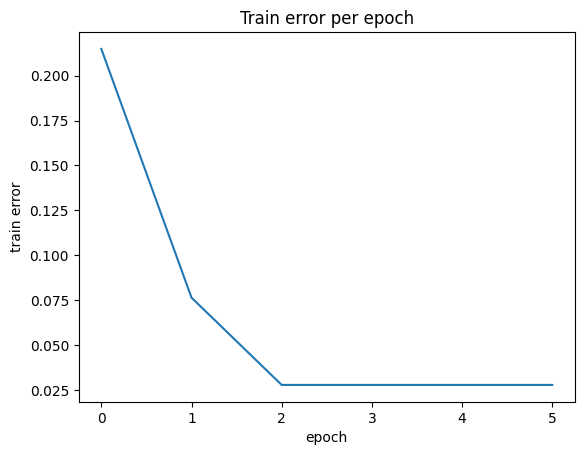

In [ ]:
import matplotlib.pyplot as plt

plt.title("Train error per epoch")
plt.plot(train_error_list)
plt.ylabel('train error')
plt.xlabel('epoch')
plt.show()

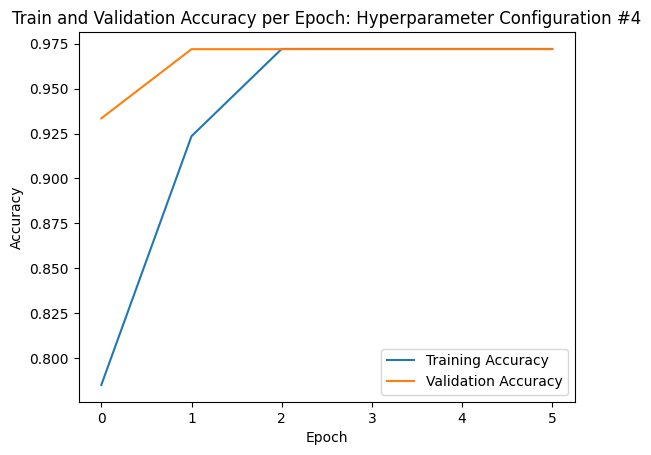

In [ ]:
train_accuracy = []
val_accuracy = []

for i in range(len(train_error_list)):
  train_accuracy.append(1-train_error_list[i])
  val_accuracy.append(1-val_error_list[i])

plt.title(f"Train and Validation Accuracy per Epoch: Hyperparameter Configuration #4")
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [ ]:
#TEST ACCURACY
index = 0
total_test_err = 0
total_test_loss = 0
total_correct = 0
for row in test_set_np[0:test_upper_bound]:
  label = torch.tensor(test_labels_np[index], dtype=torch.float32)
  input = torch.tensor(row, dtype=torch.float32)
  out = baseline_model(input)
  error = abs(round(out.item()) - round(label.item()))
  total_test_err += error
  loss = criterion(out, label)
  total_test_loss += loss.item()
  index += 1
  total_correct += (round(out.item()) == round(label.item()))
print("Total Test Error:", total_test_err)
print("Total Test Loss:", total_test_loss)
print("Number Test Samples:", index)
print("Accuracy:", total_correct/index)

Total Test Error: 1044
Total Test Loss: 48767.59946966171
Number Test Samples: 35805
Accuracy: 0.9708420611646418


In [ ]:
for i in range(num_epochs):
  print("### EPOCH: ", i)
  print("## TRAINING")
  print("Train Error: ", train_error_list[i])
  print("Train Loss: ", train_loss_list[i])
  print("Train Acc: ", train_accuracy[i])
  print("Num Samples: ",num_train_samples_list)
  print("## VALIDATION")
  print("Val Error: ", val_error_list[i])
  print("Val Loss: ", val_loss_list[i])
  print("Val Acc: ", val_accuracy[i])
  print("Num Samples: ",num_val_samples_list)

### EPOCH:  0
## TRAINING
Train Error:  0.21484358635218356
Train Loss:  1.2497164248215866
Train Acc:  0.7851564136478164
Num Samples:  [167089, 167089, 167089, 167089, 167089, 167089]
## VALIDATION
Val Error:  0.06655495042591816
Val Loss:  1.2923715059441938
Val Acc:  0.9334450495740818
Num Samples:  [35805, 35805, 35805, 35805, 35805, 35805]
### EPOCH:  1
## TRAINING
Train Error:  0.07648019917528981
Train Loss:  1.3125996081400388
Train Acc:  0.9235198008247102
Num Samples:  [167089, 167089, 167089, 167089, 167089, 167089]
## VALIDATION
Val Error:  0.028068705488060328
Val Loss:  1.3370460986491772
Val Acc:  0.9719312945119397
Num Samples:  [35805, 35805, 35805, 35805, 35805, 35805]
### EPOCH:  2
## TRAINING
Train Error:  0.02792523744830599
Train Loss:  1.333754927442716
Train Acc:  0.972074762551694
Num Samples:  [167089, 167089, 167089, 167089, 167089, 167089]
## VALIDATION
Val Error:  0.028068705488060328
Val Loss:  1.3370460986491772
Val Acc:  0.9719312945119397
Num Samples: 

In [ ]:
#TEST ACCURACY
index = 0
total_test_err = 0
total_test_loss = 0
total_correct = 0
for row in test_set_np[0:test_upper_bound]:
  label = torch.tensor(test_labels_np[index], dtype=torch.float32)
  input = torch.tensor(row, dtype=torch.float32)
  out = baseline_model(input)
  error = abs(round(out.item()) - round(label.item()))
  total_test_err += error
  loss = criterion(out, label)
  total_test_loss += loss.item()
  index += 1
  total_correct += (round(out.item()) == round(label.item()))
print("Total Test Error:", total_test_err)
print("Total Test Loss:", total_test_loss)
print("Number Test Samples:", index)
print("Accuracy:", total_correct/index)

In [ ]:
for i in range(num_epochs):
  print("### EPOCH: ", i)
  print("## TRAINING")
  print("Train Error: ", train_error_list[i])
  print("Train Loss: ", train_loss_list[i])
  print("Num Samples: ",num_train_samples_list)
  print("## VALIDATION")
  print("Val Error: ", val_error_list[i])
  print("Val Loss: ", val_loss_list[i])
  print("Num Samples: ",num_val_samples_list)

insert table here tracking error and hyper params AND accuracy


## UNUSED: Part 2: Creating Graphs, Timeseries, and Labels

### 2.1: Extracting nodes and edges from downtown core road network

In [ ]:
##################################################################
## Extracting endpoints (nodes) from the downtown core GPD
##################################################################

# Retrieving endpoints for each geometry
endpts = roads_gpd_clipped['geometry'].boundary

# Turning multipoints into single points, removing duplicates, and resetting index
endpts = endpts.explode().drop_duplicates()   # endpts now represents our nodes

# Convert the endpts GeoSeries to a GeoDataFrame
endpts_gpd = gpd.GeoDataFrame(geometry = endpts)
endpts_gpd = endpts_gpd.reset_index(drop = True)   # reorders endpts so that index starts from 0

# Creating endpts dictionary to map a given coordinate (Point()) to a node number/order
node_to_idx = {(pt[0]): ind for ind, pt in endpts_gpd.iterrows()}

In [ ]:
##################################################################
## Extracting edges and edge attributes from roads_gpd_clipped and node_to_idx
##################################################################

# Creating edge list using node_to_idx mapping
edges = []
edge_atts = []
edge_weights = []

for i, row in roads_gpd_clipped.explode().iterrows():

  # Creating undirected edge list
  start = Point(row['geometry'].coords[0])   # Wrapping in Point() since output is a tuple
  end = Point(row['geometry'].coords[-1])    # Wrapping in Point() since output is a tuple

  u_pos = node_to_idx[start]
  v_pos = node_to_idx[end]

  edges.append((u_pos, v_pos))
  edges.append((v_pos, u_pos))

  # Creating edge attribute matrix
  edge_atts.append([row['PAVSTATUS'], row['ROADCLASS'], row['NBRLANES'], row['TRAFFICDIR'], row['geometry'].length])

  # Creatng edge weight vector for compatibility with PyG GCN architecture
  edge_weights.append(row['geometry'].length)


# Duplicating the length values to match the number of directed edges
edge_weights = edge_weights + edge_weights

### 2.2: Snapping Collision Geometries to Nearest Nodes (Endpoints)

In [ ]:
##################################################################
## Creating feature_to_index mapping
##################################################################

# Note: this mapping is arbitrary
coll_features = ['INJURY_COLLISIONS', 'FTR_COLLISIONS', 'PD_COLLISIONS', 'AUTOMOBILE',	'MOTORCYCLE',	'PASSENGER', 'BICYCLE', 'PEDESTRIAN']

features = coll_features.copy()

features_to_idx = {feats: i for i, feats in enumerate(features)}

In [ ]:
print(features_to_idx)

In [ ]:
##################################################################
## Preparing DFs by snapping geometries to node geometries
##################################################################

# Using shapely STRtree to build R-tree of endpoint geometries
tree = shapely.STRtree(endpts)

# Getting target indices of nearest points to speed_avg
target_coll_idxs = tree.nearest(colls_gpd_clipped['geometry'])

# Finding snapped speed geometries from target indices
coll_snapped = tree.geometries.take(target_coll_idxs)

# Converting to GeoDataFrame
coll_snapped = gpd.GeoDataFrame(geometry = coll_snapped, crs = 'EPSG:4617')


##################################################################
## Replacing geometries in coll GPD with snapped geometries
##################################################################

# Updating coll GPD
colls_gpd_clipped.pop("geometry")
colls_gpd_clipped['geometry'] = coll_snapped['geometry']

### 2.3: Creating Timeseries and Ground Truth Labels

In [ ]:
##################################################################
## Creating list of GPDs where each entry is all collision events in a given hour
##################################################################

coll_grouped = colls_gpd_clipped.groupby(['YEAR', 'MONTH', 'DAY', 'HOUR'])   # Groups dataframe into hour-level spatial chunks

ordered_coll_list = []

for i in list(coll_grouped.groups):                      # Gets key from list of keys
  ordered_coll_list.append(coll_grouped.get_group(i))    # Uses that key to access value (which are the gpd indices) and uses that as arg for .get_group()

coll_timeseries = pd.concat(ordered_coll_list).reset_index(drop = True)


##################################################################
## Creating timepoint_to_index mapping
##################################################################

coll_timeseries_grouped = coll_timeseries.groupby(['YEAR', 'MONTH', 'DAY', 'HOUR'])
timepoints_to_idx = {pt: idx for idx, pt in enumerate(coll_timeseries_grouped.groups.keys())}

In [ ]:
##################################################################
## Creating timeseries and labels array
##################################################################

timeseries = np.zeros(shape = (len(timepoints_to_idx), len(endpts), len(features)), dtype = np.float64)
timeseries_labels = np.zeros(shape = (len(timepoints_to_idx), len(endpts), 1), dtype = np.float64)


##################################################################
## Populating timeseries with processed collision data and labels
##################################################################

# Iterating through coll_timeseries and updating timeseries and labels entries
count = 0
for i in coll_timeseries[['YEAR', 'MONTH', 'DAY', 'HOUR']].iterrows():

  # Checking if timepoint tuple is in timepoints_to_idx mapping:
  if tuple(i[1]) in timepoints_to_idx.keys():

    # If the above is True, we update the features at the correct time and node index
    timeseries[timepoints_to_idx[tuple(i[1])]][node_to_idx[coll_timeseries['geometry'].iloc[count]]][:] \
    = np.array(coll_timeseries.iloc[count][features], dtype = np.float64)

    # If the above is True, we update the labels at the correct time and node index
    timeseries_labels[timepoints_to_idx[tuple(i[1])]][node_to_idx[coll_timeseries['geometry'].iloc[count]]] = 1

  count += 1

In [ ]:
print(timeseries[0])
print("Beginning check")
for a in range(len(timeseries)):
  for i in range(len(timeseries[a])):
    for j in range(len(timeseries[a][i])):
      val = timeseries[a][i][j]
      if (val != 0.0):
        print(val)
print("End check")

In [ ]:
##################################################################
## Creating [2, E] edge tensor
##################################################################

# Creating matrix of shape [2, E] for edges
sources, targets = zip(*edges)
edge_index_tensor = torch.tensor([sources, targets], dtype=torch.long)

# Turning edge weights into torch tensor
edge_weight_tensor = torch.tensor(edge_weights, dtype = torch.float)


##################################################################
## Creating features (input) and labels tensors
##################################################################

# turning node feature timeseries into torch tensor
input = torch.tensor(timeseries, dtype = torch.float)

# turning labels into torch tensor
labels = torch.tensor(timeseries_labels, dtype = torch.float)

## UNUSED: Part 3: Preparing Input Data

### 3.1: Creating torch.tensors of Features and Labels

In [ ]:
print(input[0])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
print(labels[0])

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])


From Medium Article on weighted Loss:

# SOURCES REFERENCED

The sources referenced during the development of code for this notebook include:

Code:
 **APS360 LAB 1 CODE WAS USED AND ADAPTED FOR THE TRAINING OF THE NEURAL NETWORK MLP.**

https://stackoverflow.com/questions/30522724/take-multiple-lists-into-dataframe
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
https://stackoverflow.com/questions/16476924/how-can-i-iterate-over-rows-in-a-pandas-dataframe
https://stackoverflow.com/questions/7088625/what-is-the-most-efficient-way-to-check-if-a-value-exists-in-a-numpy-array
https://stackoverflow.com/questions/56513576/converting-tensor-to-one-hot-encoded-tensor-of-indices
https://stackoverflow.com/questions/22963263/creating-a-zero-filled-pandas-data-frame
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html
https://numpy.org/devdocs/reference/generated/numpy.zeros.html
https://stackoverflow.com/questions/69205854/iterating-over-dictionary-in-python-and-using-each-value
https://www.geeksforgeeks.org/python/pandas-how-to-shuffle-a-dataframe-rows/
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
https://www.geeksforgeeks.org/pandas/how-to-combine-two-dataframe-in-python-pandas/
https://www.geeksforgeeks.org/python/pandas-create-test-and-train-samples-from-dataframe/
https://stackoverflow.com/questions/50307707/how-do-i-convert-a-pandas-dataframe-to-a-pytorch-tensor
https://discuss.pytorch.org/t/runtimeerror-mat1-and-mat2-must-have-the-same-dtype/166759/4
https://stackoverflow.com/questions/65470807/how-to-add-a-new-dimension-to-a-pytorch-tensor
https://docs.pytorch.org/docs/stable/tensors.html
https://www.geeksforgeeks.org/python/accessing-elements-of-a-pandas-series/
https://www.w3schools.com/python/numpy/numpy_array_iterating.asp
https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
https://stackoverflow.com/questions/50275814/sigmoid-takes-1-positional-argument-but-2-were-given
https://matplotlib.org/stable/tutorials/pyplot.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/
https://stackoverflow.com/questions/49504886/converting-a-geopandas-geodataframe-into-a-pandas-dataframe
https://stackoverflow.com/questions/27241253/print-the-unique-values-in-every-column-in-a-pandas-dataframe
https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
https://www.geeksforgeeks.org/python/add-column-with-constant-value-to-pandas-dataframe/
https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-and-then-filling-it
https://www.geeksforgeeks.org/python/list-with-single-item-in-python/
https://stackoverflow.com/questions/43175382/python-create-a-pandas-data-frame-from-a-list
https://www.timeanddate.com/calendar/months/
https://stackoverflow.com/questions/70117575/geopandas-geodataframe-to-csv-file-fails-to-write-data
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
https://stackoverflow.com/questions/70117575/geopandas-geodataframe-to-csv-file-fails-to-write-data
https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/
https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
https://medium.com/@mn05052002/building-a-simple-mlp-from-scratch-using-pytorch-7d50ca66512b
https://www.kaggle.com/code/mohitchaitanya/simple-iris-dataset-classification-using-pytorch
https://www.geeksforgeeks.org/pandas/different-ways-to-iterate-over-rows-in-pandas-dataframe/
https://www.geeksforgeeks.org/deep-learning/how-to-convert-torch-tensor-to-pandas-dataframe/


Model input specifications and architecture:
https://www.mdpi.com/2071-1050/15/3/1893
https://www.jcema.com/article_91998.html
https://www.tandfonline.com/doi/full/10.1080/17457300.2025.2527668
https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
